**Task 1 (4 points). Image clustering**
You need to cluster one of the attached images (link or choose your own) using the colour description of each pixel. You can add pixel coordinates as features.

In [27]:
# Import libraries
from imageio import imread 
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np

In [28]:
ls /kaggle/input/parrot1-jpg/

parrot1.jpeg


In [29]:
# Read and show image
image_path = '/kaggle/input/parrot1-jpg/parrot1.jpeg'
image = Image.open(image_path)
image = image.convert('RGB')
pixels = np.array(image)

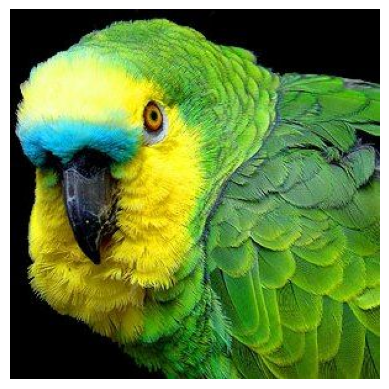

Image shape: (300, 300, 3)


In [30]:
plt.imshow(image)
plt.axis('off')
plt.show()

print("Image shape:", pixels.shape)  # Height x Width x Channels

In [31]:
height, width = pixels.shape[:2]

# Prepare data (pixel features, coordinates)
features = np.zeros((height * width, 3))  # R, G, B, X, Y
for i in range(height):
    for j in range(width):
        features[i * width + j, :3] = pixels[i, j]
        #features[i * width + j, 3:] = [i, j]
        
features.shape

(90000, 3)

In [ ]:
'''from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from joblib import Parallel, delayed

n_clusters = 8
random_state = 27

# spectral clustering
clustering = SpectralClustering(n_clusters=n_clusters, assign_labels='kmeans', random_state=random_state)
labels = clustering.fit_predict(features)


# Dimensionality Reduction with PCA
pca = PCA(n_components=2, svd_solver='full')
features_reduced = pca.fit_transform(features)

# spectral clustering on pca decomposed features
clustering = SpectralClustering(n_clusters=n_clusters, assign_labels='kmeans', 
                                random_state=random_state, n_jobs=-1)
labels = clustering.fit_predict(features_reduced)

# find centroids
centroids = np.zeros((n_clusters, 3))
for i in range(n_clusters):
    centroids[i] = np.mean(features[labels == i, :3], axis=0)

print(centroids)'''

This code runs down the python session because of lack of CPU resources, so I'll use k-means clustering

In [32]:
from sklearn.cluster import KMeans

n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=27)
kmeans.fit(features)

# Get the cluster centroids and assign the centroid colors to each pixel
centroids = kmeans.cluster_centers_[:, :3]
new_image_array = centroids[kmeans.labels_].reshape(data.shape)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [33]:
centroids # new colours

array([[ 39.08689536,  76.9935072 ,  24.47224326],
       [228.95981518, 223.86138337,  36.25315038],
       [ 84.24632733, 139.15001035,  87.88640596],
       [  2.12353337,   3.72110021,   2.31318523],
       [135.5144    , 195.99      ,  99.60493333],
       [227.43611111, 247.87222222, 147.175     ],
       [154.86712195, 144.76019512,  16.33502439],
       [105.91702749, 174.44849461,  42.56620683],
       [ 48.01986344, 189.77777778, 210.62756052],
       [ 70.66081912, 128.76125245,  21.93611965]])

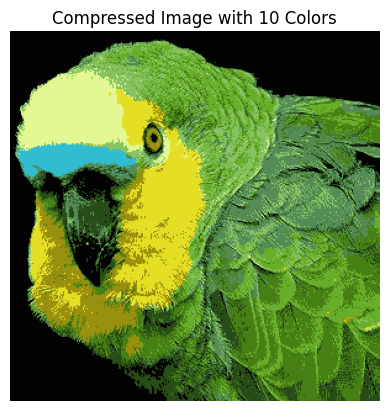

In [34]:
compressed_image = Image.fromarray((new_image_array).astype('uint8'), 'RGB')

# Display compressed image
plt.imshow(compressed_image)
plt.title(f'Compressed Image with {n_clusters} Colors')
plt.axis('off')
plt.show()

In [36]:
print(new_image_array.dtype)
print(pixels.dtype)


float64
uint8


In [37]:
compressed_image_pixels = np.array(compressed_image)
print(compressed_image_pixels.dtype)

uint8


In [38]:
original_memory = pixels.nbytes  # in bytes
compressed_memory = compressed_image_pixels.nbytes  # in bytes

print(f"Original Image Memory: {original_memory / 1024:.2f} KB")
print(f"Compressed Image Memory: {compressed_memory / 1024:.2f} KB")

Original Image Memory: 263.67 KB
Compressed Image Memory: 263.67 KB


The memory usage as reported by `.nbytes` doesn't decrease in compressed image because each pixel still occupies the same amount of memory in the array, regardless of how many colors are actually used in the image. Shape of two images are the same.

**Task 2 (3 points). Determine the optimal number of clusters**

In [52]:
import pandas as pd
# access coordinates as pd dataframe
data = pd.read_csv('/kaggle/input/elbow-txt/elbow.txt', sep='\t', header=None)
data.columns = ['x', 'y']
data

,x,y
0,"-2,74771081120538","3,57568039479491"
1,"-1,93947260410004","1,65894642258313"
2,"-2,26492186954241","2,75451531504819"
3,"-1,96353080858923","3,24751981048039"
4,"-1,37966088492499","2,88519720034044"
...,...,...
495,"3,55824183134017","-4,00098288489124"
496,"3,04809571739211","-3,71593109408841"
497,"3,68055885173358","-3,89162242121477"
498,"1,59825476600163","-3,65186339676364"


In [61]:
for col in data.columns:
    data[col] = data[col].str.replace(',', '.').astype(float)

print(data)

            x         y
0   -2.747711  3.575680
1   -1.939473  1.658946
2   -2.264922  2.754515
3   -1.963531  3.247520
4   -1.379661  2.885197
..        ...       ...
495  3.558242 -4.000983
496  3.048096 -3.715931
497  3.680559 -3.891622
498  1.598255 -3.651863
499  2.982779 -4.083988

[500 rows x 2 columns]


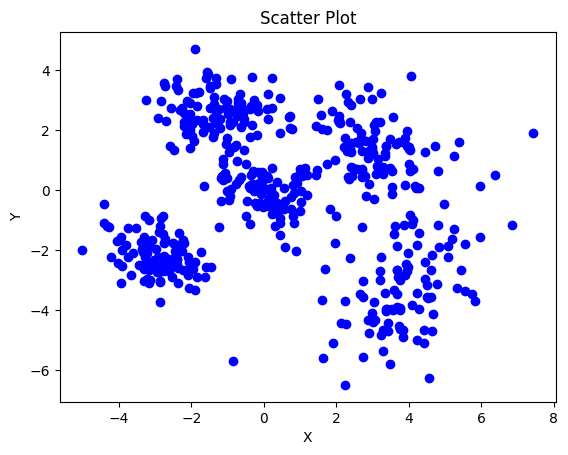

In [64]:
plt.figure()
plt.scatter(data['x'], data['y'], color='blue')

plt.title('Scatter Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

The elbow method involves plotting the sum of squared distances of samples to their closest cluster center.

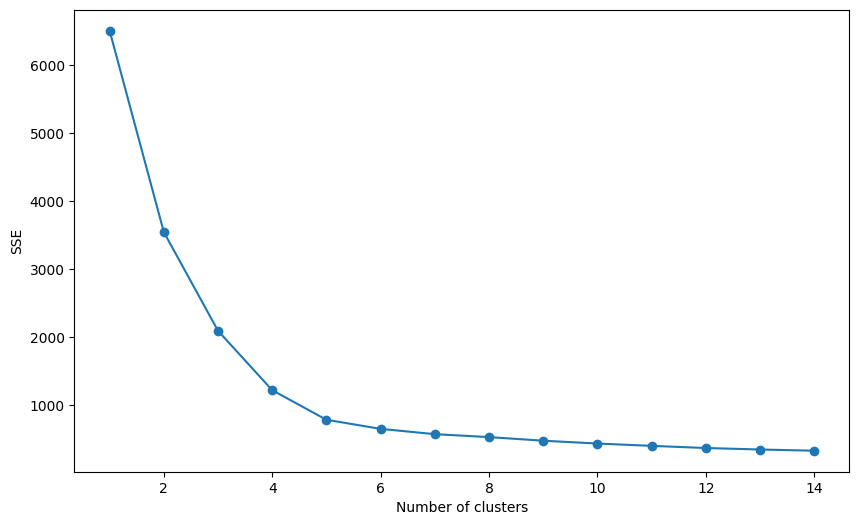

In [68]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

sse = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=27).fit(data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()


Optimal number of klusters = 5

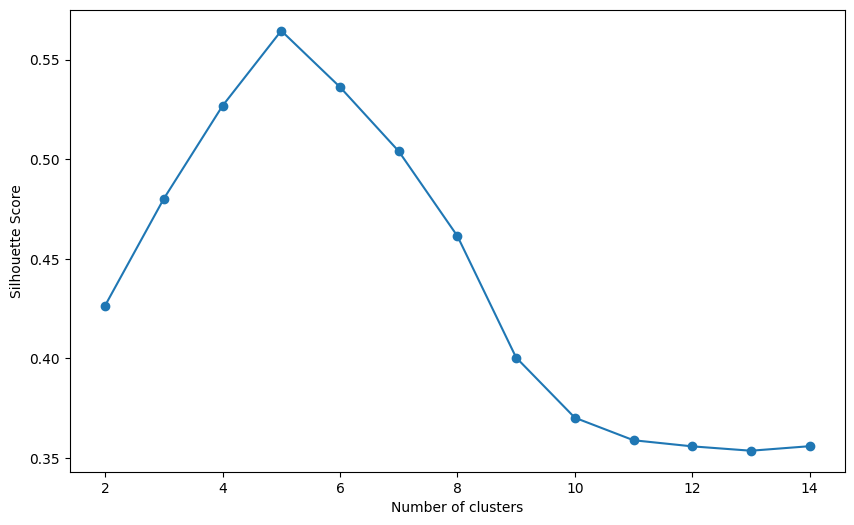

In [69]:
#The silhouette score measures how similar an object is to its own cluster 
#compared to other clusters. 

from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 15):  # silhouette_scores must be computed with more than 1 cluster
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
    score = silhouette_score(data, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()
